In [70]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error')

import string
puncs = set(string.punctuation)

In [296]:
#training sets
with open('tokenized_lower.en') as f:
    train_en = [l.strip() for l in f.readlines()][:10]
with open('tokenized_lower.fr') as f:
    train_fr = [l.strip() for l in f.readlines()][:10]

# #validation sets
# with open('val.en') as f:
#     val_en = [l.strip() for l in f.readlines()]
# with open('val.fr') as f:
#     val_fr = [l.strip() for l in f.readlines()]

# #test sets
# with open('test_2017_flickr.en') as f:
#     test_en = [l.strip() for l in f.readlines()]
# with open('test_2017_flickr.fr') as f:
#     test_fr = [l.strip() for l in f.readlines()]

In [297]:
#TODO
# 0 PAD - padding 0 for convenience in masking?
# 1 BOS - beginning of sentence
# 2 EOS - end of sentence
# 3 UNK - unknown

In [298]:
max_sentence_length = 50

In [299]:
def tokens_sentences(sentences):
    tokens_list = []
    sentence_list = []
    for s in sentences:
        split_sent = s.split()
        sentence = []
        for w in split_sent:

            if w not in puncs:
                tokens_list.append(w)
                sentence.append(w)

        sentence_list.append(sentence)
    
    return tokens_list, sentence_list

In [300]:
tokens_list_en, sentence_list_en = tokens_sentences(train_en)

tokens_train_en = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_en.extend(list(sorted(set(tokens_list_en))))
vocab_size_en = len(tokens_train_en)
print('Vocabulary size EN', vocab_size_en)

count_tokens_train_en = Counter(tokens_list_en)

tokens_list_fr, sentence_list_fr = tokens_sentences(train_fr)

tokens_train_fr = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_fr.extend(list(sorted(set(tokens_list_fr))))
vocab_size_fr = len(tokens_train_fr)
print('Vocabulary size FR', len(tokens_train_fr))

count_tokens_train_fr = Counter(tokens_list_fr)

Vocabulary size EN 74
Vocabulary size FR 77


In [301]:
def get_id_dicts(tokens):
    #default dictionary key:id value:token
    id2tokens = defaultdict(str)

    for i in range(len(tokens)):
        id2tokens[i] = tokens[i]

    #default dictionary key:token value:id
    tokens2id = defaultdict(int)

    for ind in id2tokens:
        tokens2id[id2tokens[ind]] = ind

    return tokens2id, id2tokens

In [302]:
tokens2id_en, id2tokens_en = get_id_dicts(tokens_train_en)

vocabulary_size_train_en = len(tokens2id_en)
print(vocabulary_size_train_en)

tokens2id_fr, id2tokens_fr = get_id_dicts(tokens_train_fr)

vocabulary_size_train_fr = len(tokens2id_fr)
print(vocabulary_size_train_fr)

74
77


In [303]:
def convert_corpus2id(sentence_list, tokens2id, max_sentence_length):
    
    #convert dataset to ids
    corpus2id = []
    
    for s in sentence_list:
    
        sentence2id = []
        sentence2id.append(tokens2id['<SOS>'])
    
        for w in s:
            word_id = tokens2id[w]
            sentence2id.append(word_id)
        
        
        sentence2id.append(tokens2id['<EOS>'])
        
        if len(sentence2id) < max_sentence_length:
            corpus2id.append(sentence2id)
    
        else:
            print(sentence2id)#none
            
    return corpus2id

In [304]:
corpus2id_en = convert_corpus2id(sentence_list_en, tokens2id_en, max_sentence_length)
corpus2id_fr = convert_corpus2id(sentence_list_fr, tokens2id_fr, max_sentence_length)

In [305]:
(len(corpus2id_en), len(corpus2id_fr))

(10, 10)

In [306]:
corpus2id_en[0]

[1, 65, 73, 68, 35, 5, 47, 40, 37, 9, 2]

In [307]:
class Encoder(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length):
        super(Encoder, self).__init__()
        
        self.vocab_size_fr = vocab_size_fr
        self.max_sentence_length = max_sentence_length
        
        self.w_embedding_dim = w_embedding_dim
        self.p_embedding_dim = p_embedding_dim
        
        initrange = 0.5 / self.w_embedding_dim
        self.dec_embedding_dim = dec_embedding_dim
        
        #encoder
        self.w_embeddings = nn.Embedding(self.vocab_size_fr, self.w_embedding_dim)
        self.p_embeddings = nn.Embedding(self.max_sentence_length, self.p_embedding_dim)
        
        self.w_embeddings.weight.data.uniform_(-initrange, initrange)
        self.p_embeddings.weight.data.uniform_(-initrange, initrange)
        
        
        self.context_emb_dim = self.w_embedding_dim + self.p_embedding_dim
        
        #self.context_projection = nn.Linear(self.context_emb_dim, self.dec_embedding_dim)
        #do we use non-linearity after attention
        
        #TODO: DROPOUT
        
        
    def forward(self, sent_fr, pos_fr):
        
        #embedded = self.embedding(input).view(1, 1, -1)
        #TODO:BATCH
        
        ws = []
        ps = []
        es = []
        
        for s in range(len(sent_fr)):
            word = sent_fr[s]
            pos = pos_fr[s]
            
            w_out = self.w_embeddings(word)

            p_out = self.p_embeddings(pos)

            e_out = torch.cat((w_out, p_out), 0)
    
            ws.append(w_out)
            ps.append(p_out)
            es.append(e_out)
        
        stacked_contexts = torch.stack(es, dim = 0)
        
        average_context = torch.mean(stacked_contexts, dim = 0)
            
        return average_context, stacked_contexts

class Decoder(nn.Module):
    def __init__(self, dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob):
        super(Decoder, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.max_sentence_length = max_sentence_length
        
        self.dec_embedding_dim = dec_embedding_dim*2
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        initrange = 0.5 / self.dec_embedding_dim
        self.embedding = nn.Embedding(self.vocab_size_en, self.dec_embedding_dim)
        
        self.embedding.weight.data.uniform_(-initrange, initrange)        
        
        self.rnn = nn.GRU(self.dec_embedding_dim, self.dec_embedding_dim)
        #self.bidirLSTM = nn.LSTM(self.embedding_dim, self.embedding_dim, bidirectional=True)
        #TODO: LSTM, GRU 
       
        self.pre_rnn_affine = nn.Linear(self.dec_embedding_dim*2, self.dec_embedding_dim)
        #a linear layer after this before softmax
        self.out_affine = nn.Linear(self.dec_embedding_dim, self.vocab_size_en)
               
    
    def forward(self, gold_target_sent, encoder_avg_context, encoder_stacked_contexts, train):
        
        pred = []
        attentions = []
        
        if train: #if training time
            for s in range(len(gold_target_sent)):
                gold_word = gold_target_sent[s]

                output = self.embedding(gold_word)

                output = self.dropout(output)

                if s == 0:

                    weighted_context = torch.zeros(output.shape)
                    output = torch.cat((output, weighted_context), 0)

                    output = F.relu(self.pre_rnn_affine(output))
                    #TODO: start with 0 vector as h0

                    output, hidden = self.rnn(output.view(1, 1, -1), encoder_avg_context.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])
                    s_output = F.log_softmax(s_output, dim=1) #TODO: CHECK DIM AND OUTPUT[0]

                    pred.append(s_output)

                elif s == len(gold_target_sent)-1:

                    #end of sentence
                    break

                else:

                    #start with weighted context
                    output = torch.cat((output, weighted_context), 0)

                    output = F.relu(self.pre_rnn_affine(output))

                    output, hidden = self.rnn(output.view(1, 1, -1), prev_hidden.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])

                    s_output = F.log_softmax(s_output, dim=1) #TODO: CHECK DIM AND OUTPUT[0]
                    pred.append(s_output)

                attention_weights_word = F.log_softmax(torch.matmul(encoder_stacked_contexts, prev_hidden.view(-1,1)), dim = 0)

                #print(attention_weights_word)

                weighted_context = torch.sum(torch.mul(attention_weights_word, encoder_stacked_contexts), dim = 0)

                attentions.append(attention_weights_word)


            attention_weights = torch.stack(attentions, dim=0)

            pred = torch.stack(pred, dim=0)
            
            return pred, attention_weights
        
        else: #if testing time
            
            decoder_outputs = []
            decoder_attentions = []
        
            test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
            
            test_word_id = tokens2id_en['<SOS>']
            
            for w in range(self.max_sentence_length):
       
                if test_word_id == tokens2id_en['<EOS>']:
                    
                    break  
                    
                output = self.embedding(test_word)
            
                if w == 0:
                    
                    weighted_context = torch.zeros(output.shape)
                    output = torch.cat((output.squeeze(), weighted_context.squeeze()), 0)
                    
                    output = F.relu(self.pre_rnn_affine(output))
                    #TODO: start with 0 vector as h0

                    output, hidden = self.rnn(output.view(1, 1, -1), encoder_avg_context.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])
                    s_output = F.log_softmax(s_output, dim=1) 

                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                    
                else:   
                    #start with weighted context
                    
                    output = torch.cat((output.squeeze(), weighted_context.squeeze()), 0)

                    output = F.relu(self.pre_rnn_affine(output))

                    output, hidden = self.rnn(output.view(1, 1, -1), prev_hidden.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])

                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
                    
                
                attention_weights_word = F.log_softmax(torch.matmul(encoder_stacked_contexts, prev_hidden.view(-1,1)), dim = 0)

                weighted_context = torch.sum(torch.mul(attention_weights_word, encoder_stacked_contexts), dim = 0)

                attentions.append(attention_weights_word)
                
                decoder_outputs.append(test_word_id)
                
                                  

            attention_weights = torch.stack(attentions, dim=0)            
            
            return decoder_outputs, attention_weights

    
    #https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

epoch, total loss, duration
0 4.304755544662475 0:00:00.694584
1 4.299750947952271 0:00:00.689860
2 4.294832563400268 0:00:00.680933
3 4.289986276626587 0:00:00.690179
4 4.2852273941040036 0:00:00.675375
5 4.280532598495483 0:00:00.674032
6 4.275879669189453 0:00:00.679829
7 4.27123761177063 0:00:00.700277
8 4.266607332229614 0:00:00.678356
9 4.261949968338013 0:00:00.684059
10 4.2572469234466555 0:00:00.680679
11 4.252484512329102 0:00:00.675394
12 4.247660779953003 0:00:00.681310
13 4.2427592277526855 0:00:00.689176
14 4.237760019302368 0:00:00.689526
15 4.23264856338501 0:00:00.682039
16 4.2273876667022705 0:00:01.044285
17 4.221989536285401 0:00:01.107853
18 4.216413307189941 0:00:01.146367
19 4.21064829826355 0:00:01.216374
20 4.204668807983398 0:00:00.876933
21 4.19844331741333 0:00:00.928981
22 4.191941452026367 0:00:00.800264
23 4.18512110710144 0:00:00.791324
24 4.177940559387207 0:00:00.811837
25 4.170363092422486 0:00:00.767820
26 4.162341356277466 0:00:00.708511
27 4.153823

222 2.283833658695221 0:00:00.710700
223 2.2756312489509583 0:00:00.830934
224 2.222910690307617 0:00:00.773363
225 2.214447796344757 0:00:00.741645
226 2.2538997411727903 0:00:00.842658
227 2.198846995830536 0:00:00.762001
228 2.1914022564888 0:00:00.709011
229 2.2148083806037904 0:00:00.737324
230 2.1572404742240905 0:00:00.685171
231 2.1699841141700746 0:00:00.693973
232 2.184958040714264 0:00:00.680270
233 2.1176217794418335 0:00:00.672189
234 2.122515046596527 0:00:00.672038
235 2.198878252506256 0:00:00.801592
236 2.106467068195343 0:00:00.925728
237 2.0984044551849363 0:00:00.687256
238 2.0992056131362915 0:00:00.804627
239 2.131313610076904 0:00:00.996843
240 2.1146524786949157 0:00:00.990862
241 2.072644019126892 0:00:00.910826
242 2.0829952716827393 0:00:00.864218
243 2.086139678955078 0:00:00.726612
244 2.040046548843384 0:00:00.686830
245 2.0284789323806764 0:00:00.693071
246 2.0607290625572205 0:00:00.693293
247 2.0774099349975588 0:00:00.689948
248 2.0235734581947327 0:00

440 1.0572295367717743 0:00:00.804200
441 1.0071742981672287 0:00:00.698441
442 1.0156762301921844 0:00:00.700096
443 1.044659721851349 0:00:00.718027
444 1.0316293954849243 0:00:00.748038
445 1.0078525841236115 0:00:00.890764
446 1.0335762560367585 0:00:00.678557
447 1.153234538435936 0:00:00.692861
448 1.2946719586849214 0:00:00.693341
449 1.1660731494426728 0:00:00.686602
450 1.0952616691589356 0:00:00.896410
451 0.998846834897995 0:00:00.729248
452 0.9635786056518555 0:00:00.684698
453 0.9627557694911957 0:00:00.704216
454 0.9626708000898361 0:00:00.694014
455 0.9530817687511444 0:00:00.795646
456 0.9570577532052994 0:00:00.851701
457 0.9739375352859497 0:00:00.684143
458 1.085024079680443 0:00:00.711722
459 1.2039242029190063 0:00:00.734324
460 1.07953499853611 0:00:00.700880
461 1.13052995800972 0:00:00.949121
462 0.9738915830850601 0:00:00.681942
463 0.9193048179149628 0:00:00.689840
464 0.8917346656322479 0:00:00.692266
465 0.8839100539684296 0:00:00.683299
466 0.86889662742614

657 1.0150231659412383 0:00:00.780712
658 0.7752289324998856 0:00:00.720085
659 0.6142098173499108 0:00:00.759845
660 0.5165953516960144 0:00:00.727643
661 0.4936615154147148 0:00:00.707619
662 0.48328702449798583 0:00:00.782532
663 0.47624870836734773 0:00:00.700687
664 0.49929879009723666 0:00:00.710908
665 0.523410652577877 0:00:00.863256
666 0.48180323988199236 0:00:00.779560
667 0.46313569098711016 0:00:00.703986
668 0.4629408873617649 0:00:00.733397
669 0.46669414564967154 0:00:00.949013
670 0.4904399193823338 0:00:00.868254
671 0.5053203001618385 0:00:00.758890
672 0.463238275796175 0:00:00.741389
673 0.445883359760046 0:00:00.734301
674 0.44711619466543195 0:00:00.727952
675 0.4515214301645756 0:00:00.737998
676 0.4765765093266964 0:00:00.744247
677 0.4975936278700829 0:00:00.769562
678 0.4580070324242115 0:00:00.777716
679 0.4418560765683651 0:00:00.757971
680 0.4320571176707745 0:00:00.743722
681 0.4263884149491787 0:00:00.746485
682 0.4565063163638115 0:00:00.777308
683 0.49

871 0.3428748816251755 0:00:00.693933
872 0.260110042989254 0:00:00.700558
873 0.2401429146528244 0:00:00.693187
874 0.24823044538497924 0:00:00.691909
875 0.24212183207273483 0:00:00.717113
876 0.2406304657459259 0:00:00.689738
877 0.2381725236773491 0:00:00.676821
878 0.26064779609441757 0:00:00.695886
879 0.34733943194150924 0:00:00.700260
880 0.5136924877762794 0:00:00.696128
881 0.625143188983202 0:00:00.684882
882 1.179466849565506 0:00:00.799938
883 0.837688498198986 0:00:00.767507
884 0.5144072525203228 0:00:00.730719
885 0.43551072403788565 0:00:00.683790
886 0.3906442128121853 0:00:00.690841
887 0.28932941779494287 0:00:00.684100
888 0.26951806917786597 0:00:00.682268
889 0.25986953601241114 0:00:00.726355
890 0.2534873940050602 0:00:00.792799
891 0.24872235357761383 0:00:00.718568
892 0.24413080960512162 0:00:00.693718
893 0.2407438725233078 0:00:00.714592
894 0.2373521387577057 0:00:00.690258
895 0.23569355905056 0:00:00.685172
896 0.23413362205028534 0:00:00.691132
897 0.2

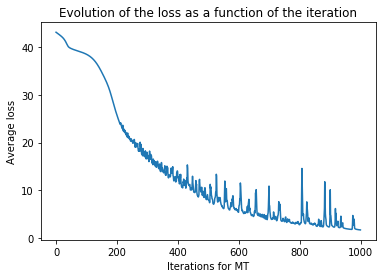

['<SOS>', 'deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '<EOS>']
['<SOS>', 'two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '<EOS>']
['a', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '<EOS>']


In [313]:
epochs = 1000
learning_rate = 0.01
w_embedding_dim = 300
p_embedding_dim = 300
dec_embedding_dim = 300
dropout_prob = 0.1

model_encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
model_decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)

optimizer_encoder = optim.SGD(model_encoder.parameters(), lr = learning_rate)
optimizer_decoder = optim.SGD(model_decoder.parameters(), lr = learning_rate)

loss_func = nn.NLLLoss()
losses = []
avg_losses = []

portion = 10

train = True
print('epoch, total loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for s in range(portion):
     
        current_input = corpus2id_fr[s]
        gold_output = corpus2id_en[s]
        
        if len(current_input) > 0 and len(gold_output) > 0:
            
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            
            sent_fr = torch.tensor(np.asarray(current_input), dtype= torch.long)
            sent_en = torch.tensor(np.asarray(gold_output), dtype= torch.long)

            pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
            pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))

            average_context, stacked_contexts = model_encoder(sent_fr, pos_fr)
        
            pred, attention_weights = model_decoder(sent_en, average_context, stacked_contexts, train)
            
            #print(pred, sent_en)
            sent_en = sent_en[1:len(sent_en)] #skip SOS
            loss = loss_func(pred.squeeze(), sent_en)
        
            loss.backward()

            optimizer_encoder.step()
            optimizer_decoder.step()

            total_loss += loss.item() 
       
    now = datetime.now()
        
    losses.append(total_loss)
    
    print(e, total_loss/portion, now-then)
    

with open('model_encoder' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_encoder,file)
      

with open('model_decoder' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_decoder,file)
    
iteration= list(range(len(losses)))

plt.plot(iteration, losses)
plt.xlabel("Iterations for MT")
plt.ylabel('Average loss')
plt.title('Evolution of the loss as a function of the iteration')
plt.savefig("mt" + str(portion)+".png")
plt.show()

test_fr_sentence = corpus2id_fr[0]
test_en_sentence = corpus2id_en[0]
    
decoder_outputs, decoder_attentions = evaluate_test(model_encoder, model_decoder,test_fr_sentence, test_en_sentence)

print(word_ids2string(test_fr_sentence, id2tokens_fr))
print(word_ids2string(test_en_sentence, id2tokens_en))
print(word_ids2string(decoder_outputs, id2tokens_en))

In [317]:
pair = 7

test_fr_sentence = corpus2id_fr[pair]
test_en_sentence = corpus2id_en[pair]
    
decoder_outputs, decoder_attentions = evaluate_test(model_encoder, model_decoder,test_fr_sentence, test_en_sentence)

print(word_ids2string(test_fr_sentence, id2tokens_fr))
print(word_ids2string(test_en_sentence, id2tokens_en))
print(word_ids2string(decoder_outputs, id2tokens_en))

['<SOS>', 'une', 'fille', 'branchée', 'parle', 'à', 'son', 'portable', 'tout', 'en', 'glissant', 'lentement', 'dans', 'la', 'rue', '<EOS>']
['<SOS>', 'a', 'trendy', 'girl', 'talking', 'on', 'her', 'cellphone', 'while', 'gliding', 'slowly', 'down', 'the', 'street', '<EOS>']
['a', 'trendy', 'girl', 'talking', 'on', 'her', 'cellphone', 'while', 'gliding', 'slowly', 'down', 'the', 'street', '<EOS>']


In [ ]:
with open('model_encoder' + str(portion) + '.pickle','rb') as file:
    model_encoder = pickle.load(file)
      

with open('model_decoder' + str(portion) + '.pickle','rb') as file:
    model_decoder = pickle.load(file)

In [202]:
def evaluate_test(model_encoder, model_decoder, sent_fr, sent_en):
    
    with torch.no_grad():
        
        sent_fr = torch.tensor(np.asarray(sent_fr), dtype= torch.long)
        sent_en = torch.tensor(np.asarray(sent_en), dtype= torch.long)

        pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
        pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))

        average_context, stacked_contexts = model_encoder(sent_fr, pos_fr)
        
        decoder_outputs, decoder_attentions = model_decoder(sent_en, average_context, stacked_contexts, train=False)
    
    return decoder_outputs, decoder_attentions

In [16]:
def word_ids2string(sentence, id2token):
    
    converted = []

    for s in sentence:
        converted.append(id2token[s])
        
    return converted

In [17]:
#TODO
#BEAM SEARCH
#teacher forcing prob
#dropout prob
#gru lstm rnn check
#relu before rnn?

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def visualize_attention(model, sentence):
    
    #model_encoder, model_decoder, sent_en, sent_fr
    
#************************************************************************
# A is the attention torch Tensor: the output of your model
# S is the softmax version of S, also a torch Tensor! (actually more acurately it's a Variable(Tensor(..))
#************************************************************************

    # Plot the attention tensor
    plt.clf()
    numpy_S = S.data.numpy() # get the data in Variable, and then the torch Tensor as numpy array
    plt.imshow(numpy_S)
    plt.savefig("attention-sent-{}-epoch-{}".format(i, step))

In [135]:
a = torch.tensor(np.asarray([i for i in range(10)]), dtype= torch.float)

In [286]:
a

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [140]:
asf = F.log_softmax(a, dim=0)
print(asf)

tensor([-9.4586, -8.4586, -7.4586, -6.4586, -5.4586, -4.4586, -3.4586,
        -2.4586, -1.4586, -0.4586])


In [287]:
a*0.1

tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,
         0.7000,  0.8000,  0.9000])

In [161]:
b = torch.tensor(np.asarray([i+1 for i in range(10)]), dtype= torch.float)

In [318]:
st = torch.stack([a,b], dim = 0)
print(st)

tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
        [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]])


In [343]:
weights = torch.tensor(np.asarray([0.1, 0.2]), dtype = torch.float).view(-1,1)
print(weights.shape)

torch.mul(weights, st)
# torch.matmul(weights.view(1,2), st)

torch.Size([2, 1])


tensor([[ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,
          0.7000,  0.8000,  0.9000],
        [ 0.2000,  0.4000,  0.6000,  0.8000,  1.0000,  1.2000,  1.4000,
          1.6000,  1.8000,  2.0000]])

In [163]:
torch.stack([a,b], dim = 1)

tensor([[  0.,   1.],
        [  1.,   2.],
        [  2.,   3.],
        [  3.,   4.],
        [  4.,   5.],
        [  5.,   6.],
        [  6.,   7.],
        [  7.,   8.],
        [  8.,   9.],
        [  9.,  10.]])

In [164]:
torch.mean(st, dim = 1)

tensor([ 4.5000,  5.5000])

In [166]:
torch.mean(st, dim = 0)

tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,
         7.5000,  8.5000,  9.5000])

In [176]:
F.softmax(st, dim = 0)

tensor([[ 0.2689,  0.2689,  0.2689,  0.2689,  0.2689,  0.2689,  0.2689,
          0.2689,  0.2689,  0.2689],
        [ 0.7311,  0.7311,  0.7311,  0.7311,  0.7311,  0.7311,  0.7311,
          0.7311,  0.7311,  0.7311]])

In [390]:
a = a*-1

In [405]:
long(torch.argmax(a))

NameError: name 'long' is not defined

In [469]:
test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
print(test_word, test_word.shape)

tensor([ 1]) torch.Size([1])


In [ ]:

#     attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                  encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         output = self.attn_combine(output).unsqueeze(0)
           
#         atts= torch.matmul(es, hidden_from_decoder)
        
#         weighted_context = es*attention_weights
        
        #if EOS for encoder, move on to the decoder
        
        #attention_matrices = self.attention_projection(e_out)
        
        #input embedding
        #set hidden at the beginning
        #get rnn output
        #apply softmax

        #feed actual word for training
        #feed previous word for testing

#             #view_shape = embeddings.shape[0]
#             output, (hidden, cell) = self.bidirLSTM(embeddings.view(1, 1, -1)) 

#             hid_f = hidden[0]
#             hid_b = hidden[1]